In [4]:
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from collections import defaultdict
import time

In [13]:

class BlackjackEnvironment:
    def __init__(self, min_bet, max_bet):
        """
        A Blackjack environment that adjusts rewards based on a bet
        determined by the card count.

        Args:
            min_bet (int): the minimum bet
            max_bet (int): the maximum bet
        """
        self.min_bet = min_bet
        self.max_bet = max_bet
        
        self.deck = self._create_new_deck()
        self.player_cards = []
        self.dealer_cards = []
        
        self.has_doubled_down = False
        self.game_over = False
        
        # Tracking rewards
        self.rewards = []

        # We'll track the bet for the current round
        self.current_bet = self.min_bet

        # Initialize / reset the game at the start
        self.reset_game()

    def _create_new_deck(self):
        suits = ['hearts', 'diamonds', 'clubs', 'spades']
        values = list(range(2, 11)) + ['jack', 'queen', 'king', 'ace']
        deck = [f"{value}_{suit}" for value in values for suit in suits]
        random.shuffle(deck)
        return deck

    def _draw_random_card(self):
        return self.deck.pop()

    def reset_game(self):
        """
        Resets for a new round:
          1) Creates a new deck
          2) Deals 2 cards to Player
          3) Deals 2 cards to Dealer
          4) Resets flags
          5) Recomputes the bet based on the new deck's initial card count
        """
        self.deck = self._create_new_deck()
        self.player_cards = [self._draw_random_card(), self._draw_random_card()]
        self.dealer_cards = [self._draw_random_card(), self._draw_random_card()]
        
        self.has_doubled_down = False
        self.game_over = False
       

        # Determine the bet for this round from the card count
        self.current_bet = self.calculate_bet()

    def _get_card_value(self, card):
        value = card.split('_')[0]
        if value in ['jack', 'queen', 'king']:
            return 10
        elif value == 'ace':
            return 11
        else:
            return int(value)

    def _calculate_hand_value(self, hand):
        total = sum(self._get_card_value(card) for card in hand)
        # Adjust for Aces if we're over 21
        aces = sum(card.startswith('ace') for card in hand)
        while total > 21 and aces > 0:
            total -= 10
            aces -= 1
        return total

    def _has_soft_hand(self, hand):
        total_without_ace_adjust = sum(
            1 if card.startswith('ace') else self._get_card_value(card)
            for card in hand
        )
        total = self._calculate_hand_value(hand)
        return (total != total_without_ace_adjust)

    def _check_if_busted(self, hand):
        return self._calculate_hand_value(hand) > 21

    def _check_natural_blackjack(self, hand):
        return len(hand) == 2 and self._calculate_hand_value(hand) == 21

    def _play_dealer_hand(self):
        """
        Dealer hits until total is 17 or more (soft 17 rule optional).
        """
        while self._calculate_hand_value(self.dealer_cards) < 17:
            self.dealer_cards.append(self._draw_random_card())

    def _finalize_round(self):
        """
        Compares player's hand vs. dealer's hand to assign final rewards.
        """
        player_value = self._calculate_hand_value(self.player_cards)
        dealer_value = self._calculate_hand_value(self.dealer_cards)

        # If dealer busts, player automatically wins
        if self._check_if_busted(self.dealer_cards):
            reward = (2 if self.has_doubled_down else 1) * self.current_bet
            self.rewards.append(reward)
            return 'terminal', reward, True

        # Compare values
        if player_value > dealer_value:
            # Player wins
            reward = (2 if self.has_doubled_down else 1) * self.current_bet
        elif player_value < dealer_value:
            # Dealer wins
            reward = (-2 if self.has_doubled_down else -1) * self.current_bet
        else:
            # Tie
            reward = 0

        self.rewards.append(reward)
        return 'terminal', reward, True

 
    def count_hand(self, hand):
        """
        Basic Hi-Lo style counting:
          +1 for low cards (2..6),
          -1 for 10s and Aces,
           0 for 7..9 and any other.
        """
        count = 0
        for card in hand:
            val = self._get_card_value(card)
            if val in [2, 3, 4, 5, 6]:
                count += 1
           
            elif val == 10 or val == 11:  # Ace = 11 by default in this code
                count -= 1
           
        return count

    def calculate_count(self, player_hand, dealer_hand):
        """
        Compute combined count from known cards (player + dealer).
        For a more advanced approach, also count "burned" cards,
        and keep a running tally across multiple rounds in a shoe.
        """
        total_count = self.count_hand(player_hand) + self.count_hand(dealer_hand)
        # You could also consider the entire deck or partial deck seen. 
        return total_count

    def calculate_bet(self):
        """
        Decide on a bet for this round based on the card count.
        E.g. a simple approach:
          - If count >= 2 => use max_bet
          - else => use min_bet
        """
        current_count = self.calculate_count(self.player_cards, self.dealer_cards)
        if current_count >= 2:
            return self.max_bet
        else:
            return self.min_bet

   
    def get_current_state(self):
        player_value = self._calculate_hand_value(self.player_cards)
        dealer_up_card_value = self._get_card_value(self.dealer_cards[0])
        is_soft = self._has_soft_hand(self.player_cards)
        count_info = self.calculate_count(self.player_cards, self.dealer_cards)
        return (player_value, dealer_up_card_value, is_soft, self.has_doubled_down, count_info)

    
    def step(self, action):
        if self.game_over:
            return 'terminal', 0, True
        if self._check_natural_blackjack(self.player_cards):
            # A natural blackjack might pay 1.5x, or 1:1, depending on your rules
            # We'll do +1.5 * current_bet
            reward = 1.5 * self.current_bet
            self.rewards.append(reward)
            self.game_over = True
            return 'terminal', reward, True

        if action == 'h':
            self.player_cards.append(self._draw_random_card())
            if self._check_if_busted(self.player_cards):
                # Busted => immediate negative
                reward = (-2 if self.has_doubled_down else -1) * self.current_bet
                self.rewards.append(reward)
                self.game_over = True
                return 'terminal', reward, True
            else:
                return self.get_current_state(), 0, False

        elif action == 's':
            self._play_dealer_hand()
            next_state, reward, done = self._finalize_round()
            self.game_over = True
            return next_state, reward, done

        elif action == 'd':
            self.has_doubled_down = True
            self.player_cards.append(self._draw_random_card())
            if self._check_if_busted(self.player_cards):
                reward = -2 * self.current_bet
                self.rewards.append(reward)
                self.game_over = True
                return 'terminal', reward, True
            else:
                self._play_dealer_hand()
                next_state, reward, done = self._finalize_round()
                self.game_over = True
                return next_state, reward, done

        else:
            raise ValueError("Invalid action.")


Q-learning

In [14]:
#class Qlearning

class QLearningAgent:
   def __init__(self, environment, num_episodes, initial_epsilon, epsilon_decay, final_epsilon, alpha, gamma):
         # initialize the Q-learning agent with the given environment and learning parameters
         self.environment = environment
         self.alpha = alpha  # learning rate
         self.gamma = gamma  # discount factor
         self.initial_epsilon = initial_epsilon  # exploration rate
         self.epsilon = self.initial_epsilon
         self.num_episodes = num_episodes  # number of episodes to train
         self.epsilon_decay = epsilon_decay  # decay rate for epsilon
         self.final_epsilon = final_epsilon
         self.Q_values = {}  # Q-value dictionary mapping (state, action) pairs to Q-values
         self.epsilon_values = []
         self.epsilon = 0
         self.q_table = {}
         self.action_counts = {'h': 0, 's': 0, 'd': 0}
         

   # Method to extract the policy
   def get_policy(self):
         policy = {}
         for state, actions in self.q_table.items():
               # Find the action with the highest Q-value
               best_action = max(actions, key=actions.get)
               policy[state] = best_action
         return policy
      
   def get_q_table(self):
   
         for (state, action), q_value in self.Q_values.items():
            if state == 'terminal':
                  continue 
            if state not in self.q_table:
                  self.q_table[state] = {}
            self.q_table[state][action] = q_value

         return self.q_table
         


   def get_q_value(self, state, action):
      # get the Q-value for a given state-action pair
      return self.Q_values.get((state, action), 0)
   
   def select_action(self, state):
   
         valid_actions = ['h', 's','d']
         if np.random.random() < self.epsilon:
               action = random.choice(valid_actions)   
         else:
               action = max(valid_actions, key=lambda action: self.Q_values.get((state, action), 0))

         self.action_counts[action] += 1  # Increment the count for the selected action
         return action    

   def update_q_value(self, state, action, next_state, reward):
         # update the Q-value table using the Q-learning update rule
         
         current_q = self.get_q_value(state, action)
         next_q = max(self.get_q_value(next_state, a) for a in ['h', 's','d'])
         temporal_difference = reward + self.gamma * next_q - current_q
         self.Q_values[(state, action)] = current_q + self.alpha * temporal_difference


      
   def decay_epsilon(self,num_episode):

         #exp decay
         
         self.epsilon = max(self.final_epsilon, self.initial_epsilon * (self.epsilon_decay ** num_episode))


   
   def train_agent(self, num_episodes):
         # train the Q-learning agent by running the algorithm for the specified number of episodes
         for episode in range(num_episodes):
               self.environment.reset_game()
               state = self.environment.get_current_state()
               done = False
               while not done:
                  action = self.select_action(state)
                  next_state, reward, done = self.environment.step(action)
                  self.update_q_value(state, action, next_state, reward)
                  state = next_state  
               
               
               self.decay_epsilon(num_episode= episode)  # Decay epsilon after each episode
               self.epsilon_values.append(self.epsilon)
         
         print("Action Counts:", self.action_counts)
      


In [21]:
# training phase
start = time.time()
num_episodes = 1500000

learning_rate = 0.1
discount_factor = 0.9

initial_epsilon = 1.0
final_epsilon = 0.05
#epsilon_decay = 0.99998
epsilon_decay = (final_epsilon / initial_epsilon) ** (1 / num_episodes)

min_bet =1
max_bet =10
# Initialize the environment and the Q-learning agent
environment = BlackjackEnvironment(min_bet, max_bet)
agent = QLearningAgent(environment, num_episodes, initial_epsilon, epsilon_decay, final_epsilon, learning_rate, discount_factor)

agent.train_agent(num_episodes)
q_table = agent.get_q_table()
policy = agent.get_policy()


# evaluate the performance of the trained agent over a number of games
num_games = 10000
win_count = 0
loss_count = 0
draw_count = 0
total_reward = 0

for _ in range(num_games):
   
      agent.environment.reset_game()
      state = agent.environment.get_current_state()
      game_done = False

      while not game_done:
         action = agent.select_action(state)
         state, reward, game_done = agent.environment.step(action)
         total_reward += reward
         
      if reward > 0:
         win_count += 1
      elif reward < 0:
         loss_count += 1
      else:
         draw_count += 1

end = time.time()
print(f"Total time: {end-start:0.2f} seconds")
winning_rate = win_count / num_games
losing_rate = loss_count / num_games
draw_rate = draw_count / num_games

print(f"Basic Strategy - QLearning: Winning rate: {winning_rate:.4f}, Losing rate: {losing_rate:.4f}, Draw rate: {draw_rate:.4f}")




Action Counts: {'h': 874856, 's': 880550, 'd': 312064}
Total time: 43.80 seconds
Basic Strategy - QLearning: Winning rate: 0.4222, Losing rate: 0.4999, Draw rate: 0.0779


In [17]:
print('policy:', policy)

policy: {(13, 11, False, False, -2): 'h', (16, 11, False, False, -1): 'h', (18, 11, False, False, 0): 's', (14, 4, False, False, 1): 'h', (17, 3, True, False, 0): 'h', (20, 8, False, False, -2): 's', (20, 5, False, False, -2): 's', (11, 10, False, False, -1): 'h', (20, 10, False, False, -1): 's', (16, 3, False, False, 1): 's', (14, 10, True, False, 0): 'h', (14, 10, False, False, -1): 'h', (14, 2, False, False, 0): 'h', (11, 3, False, False, 3): 'h', (12, 10, True, False, -2): 'h', (16, 10, True, False, -1): 'h', (21, 8, True, False, -1): 's', (13, 10, False, False, -1): 'h', (15, 10, False, False, -2): 'h', (10, 10, False, False, 1): 'h', (16, 10, False, False, 0): 'h', (20, 10, False, False, 1): 's', (19, 10, False, False, -3): 'h', (17, 10, False, False, -2): 'h', (10, 10, False, False, 0): 'h', (15, 10, True, False, -1): 'h', (15, 2, False, False, 0): 'h', (16, 11, False, False, 0): 's', (15, 10, False, False, -1): 'h', (17, 10, False, False, 0): 's', (19, 6, False, False, -1): 's'

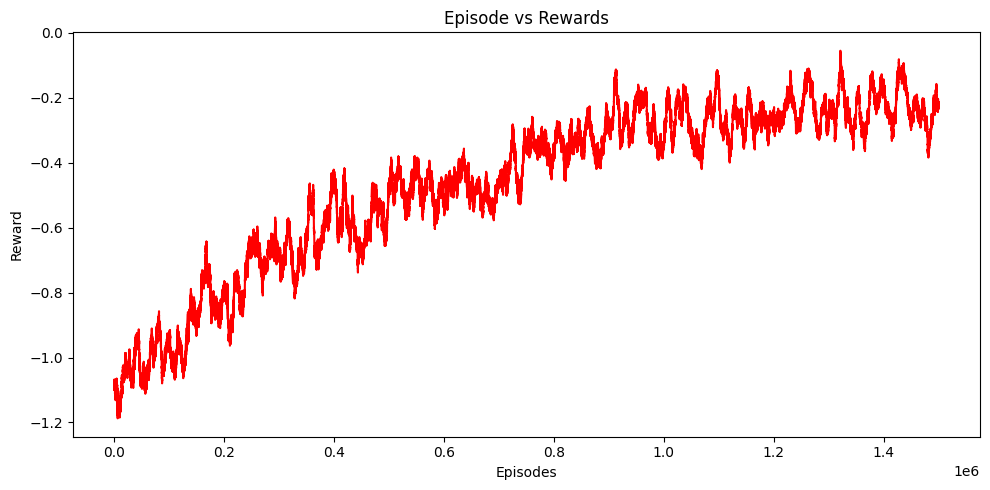

In [22]:


# Plot the reward moving average
length_step = 10000
reward_moving_average = (np.convolve(np.array(agent.environment.rewards).flatten(), np.ones(length_step), mode="valid") / length_step)
plt.figure(figsize=(10, 5))
plt.title('Episode vs Rewards')
plt.xlabel('Episodes')
plt.ylabel('Reward')
plt.plot(range(len(reward_moving_average)), reward_moving_average, color='red')
plt.tight_layout()
plt.show()

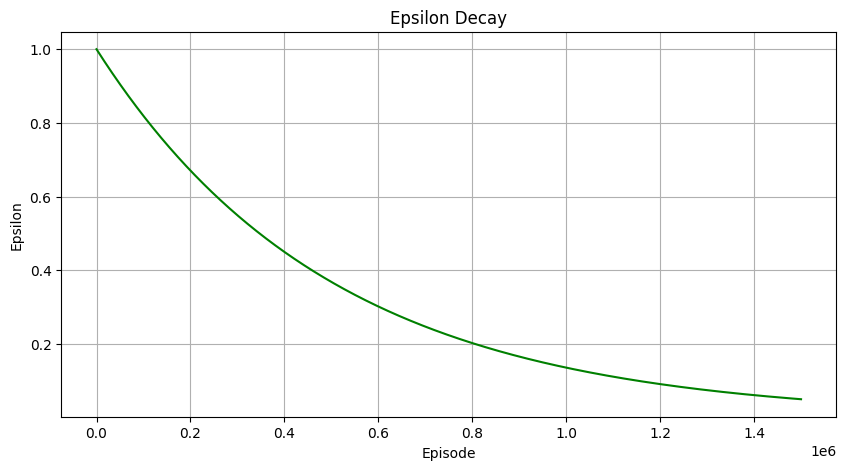

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))

# Plot epsilon values
ax.plot(range(len(agent.epsilon_values)), agent.epsilon_values, color='green')

# Set labels, title, and grid
ax.set_xlabel('Episode')
ax.set_ylabel('Epsilon')
ax.set_title('Epsilon Decay')
ax.grid()

plt.show()